In [1]:
import pandas as pd
import numpy as np
import phdTools
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as transforms
from matplotlib.legend import Legend
from matplotlib import rc
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [2]:
from IPython.display import display, set_matplotlib_formats

In [3]:
# Set the matplotlib graphs to be exported as svg
set_matplotlib_formats('svg')

In [4]:
# Output markdown to cells
from IPython.display import Markdown

In [5]:
# Set seed for reproducility
seed_value=423
random.seed(seed_value)
np.random.seed(seed_value)

---
# Peak event response data

In [6]:
# Read the Peak event response data
url_path = 'https://data.gov.au/dataset/4e21dea3-9b87-4610-94c7-15a8a77907ef/resource/2ea70e4e-da2a-42d8-94dc-c12b801d45b7/download/sgsc-ctpeak-event-response.csv'
peak_response_df = pd.read_csv(url_path)

In [7]:
# Trim leading and trailing whitespaces in column names
peak_response_df.columns = peak_response_df.columns.str.strip()

In [8]:
peak_response_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26263 entries, 0 to 26262
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CUSTOMER_KEY   26263 non-null  int64  
 1   EVENT_KEY      26263 non-null  int64  
 2   ACTUAL_KWH     12024 non-null  float64
 3   BASELINE_KWH   12024 non-null  float64
 4   REBATE_AMOUNT  12032 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.0 MB


A more detailed explanation of the above data is:
* `ACTUAL_KWH` : customer's actual usage in kWh during peak network event (for **Rebate product only**).
* `BASELINE_KWH` : customer's usage in kWh preceding peak network event *as called* by the electricity retailer or distribution business (for **Rebate product only**).
* `REBATE_AMOUNT` : the rebate amount per event in *Australian dollars*.

How is the *rebate amount* **calculated**?? Is it the same methodology for each event and customer??

Next we use the peak event data and merge it with the response data so that we can also have a view of the type of these peak events.

In [9]:
# Read Peak event data
url_path = 'https://data.gov.au/dataset/4e21dea3-9b87-4610-94c7-15a8a77907ef/resource/e45517ea-189a-4d61-b02d-bd7d85b0f156/download/sgsc-ctpeak-events.csv'
peak_event_df = pd.read_csv(url_path)

# Trim leading and trailing whitespaces in column names
peak_event_df.columns = peak_event_df.columns.str.strip()

In [10]:
peak_event_unique =  peak_response_df.EVENT_KEY.unique()
DPR_event_unique = peak_event_df[peak_event_df.PEAK_EVENT_TYPE == 'DPR'].EVENT_KEY
intersection_DPR = set(peak_event_unique) & set(DPR_event_unique)
intersection_DPR

{1000240,
 1000241,
 1000242,
 1000244,
 1000245,
 1000246,
 1000248,
 1000250,
 1000251,
 1000252,
 1000253,
 1000258,
 1000261,
 1000265,
 1000266}

In [11]:
peak_event_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   EVENT_KEY           29 non-null     int64 
 1   PEAK_EVENT_TYPE     29 non-null     object
 2   EVENT_DATE          28 non-null     object
 3   START_TIMESTAMP     28 non-null     object
 4   END_TIMESTAMP       28 non-null     object
 5   HALF_HOUR_START_CD  28 non-null     object
 6   HALF_HOUR_END_CD    28 non-null     object
dtypes: int64(1), object(6)
memory usage: 1.7+ KB


In [12]:
peak_event_df.PEAK_EVENT_TYPE.unique()

array(['DPR', 'DPP', 'Not a Peak Event'], dtype=object)

In [13]:
# DPR event keys found in the `peak_event_df`
np.sort(peak_event_df[peak_event_df.PEAK_EVENT_TYPE == 'DPR']['EVENT_KEY'].unique())

array([1000240, 1000241, 1000242, 1000244, 1000245, 1000246, 1000248,
       1000249, 1000250, 1000251, 1000252, 1000253, 1000254, 1000256,
       1000258, 1000261, 1000265, 1000266], dtype=int64)

In [14]:
# Get DPR and DPP event keys
DPR_event_keys = peak_event_df[peak_event_df.PEAK_EVENT_TYPE == 'DPR'].EVENT_KEY.values
DPP_event_keys = peak_event_df[peak_event_df.PEAK_EVENT_TYPE == 'DPP'].EVENT_KEY.values

# Create DPR and DPP masks
DPR_mask = peak_response_df.EVENT_KEY.isin(DPR_event_keys)
DPP_mask = peak_response_df.EVENT_KEY.isin(DPP_event_keys)

# Add the `PEAK_EVENT_TYPE` column and populate it 
peak_response_df.loc[DPR_mask, 'PEAK_EVENT_TYPE'] = 'DPR'
peak_response_df.loc[DPP_mask, 'PEAK_EVENT_TYPE'] = 'DPP'

In [15]:
peak_response_df[peak_response_df.PEAK_EVENT_TYPE == "DPR"].EVENT_KEY.unique().shape

(15,)

In [16]:
peak_response_df.shape

(26263, 6)

#### Rebate product data

In [17]:
# Select only the responses for DPR events
DPR_response_df = peak_response_df[peak_response_df.PEAK_EVENT_TYPE == 'DPR'].copy()

# Drop the cases where there are no baseline and actual usage data
DPR_response_df.dropna(inplace=True)

In [18]:
# Event that have only missing values for consumption data
DPR_resp_unique = peak_response_df[peak_response_df.PEAK_EVENT_TYPE == "DPR"].EVENT_KEY.unique()
DPR_resp_unique_notna = DPR_response_df.EVENT_KEY.unique()
intersection_DPR_notna = set(DPR_resp_unique_notna) ^ set(DPR_resp_unique)
intersection_DPR_notna

{1000252, 1000253}

In [19]:
# DPR event keys found in the `peak_response_df`
np.sort(DPR_response_df.EVENT_KEY.unique()).shape

(13,)

In [20]:
Markdown('The **total** number of entries with **complete** data is *{}*, and the unique number of customers with complete data is *{}*.'.format(DPR_response_df.shape[0],len(DPR_response_df.CUSTOMER_KEY.unique())))

The **total** number of entries with **complete** data is *12024*, and the unique number of customers with complete data is *1256*.

In [21]:
Markdown('We have complete DPR customer data for **{} events**.'.format(len(DPR_response_df['EVENT_KEY'].unique()))) 

We have complete DPR customer data for **13 events**.

In [22]:
# Table with the list of peak events each customer has participated
customer_peak_event_df = pd.DataFrame(DPR_response_df.groupby(DPR_response_df.CUSTOMER_KEY)['EVENT_KEY'].apply(list))

# Add a column with the number of events
customer_peak_event_df['no_events_participated'] = customer_peak_event_df.EVENT_KEY.apply(len)

customer_peak_event_df.head()

EVENT_KEY  \
CUSTOMER_KEY                                                      
8144683                             [1000245, 1000246, 1000248]   
8145435       [1000266, 1000258, 1000242, 1000250, 1000248, ...   
8145987       [1000248, 1000242, 1000266, 1000251, 1000246, ...   
8145997       [1000258, 1000248, 1000251, 1000246, 1000245, ...   
8146093       [1000250, 1000246, 1000245, 1000244, 1000265, ...   

              no_events_participated  
CUSTOMER_KEY                          
8144683                            3  
8145435                           11  
8145987                           11  
8145997                           11  
8146093                           10

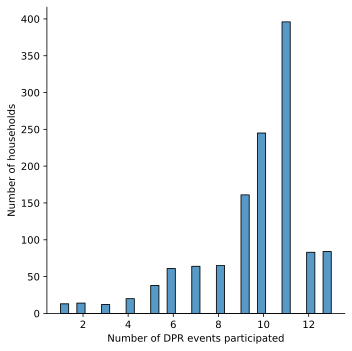

In [23]:
# Histogram showing the distribution of how many customers have responded to how many events
sns.displot(customer_peak_event_df['no_events_participated']) #, stat="probability")
plt.xlabel('Number of DPR events participated')
plt.ylabel('Number of households')
plt.show()

---
The metric that has been selected to be used as a proxy for how households have responded to DPR events is the *percentage difference between their actual consumption and their baseline estimation*. The baseline estimation is based on methodologies of the aggregators/service providers.

##### *Percentage difference between actual and baseline consumption* 

In [24]:
Markdown("The *min* value of actual electicity usage is *{}* and the *max* is *{}*, whereas the *min* value of baseline electicity usage is **{}** and the *max* is **{}**".format(DPR_response_df['ACTUAL_KWH'].min(), DPR_response_df['ACTUAL_KWH'].max(), DPR_response_df['BASELINE_KWH'].min(), DPR_response_df['BASELINE_KWH'].max()))

The *min* value of actual electicity usage is *0.0* and the *max* is *39.5645*, whereas the *min* value of baseline electicity usage is **0.0** and the *max* is **50.972484**

We filter out the lines where the baseline consumption is really low (**potentially faulty**). We select cases where the baseline consumption is more than $0.01 \,kWh$, based on the typical electricity consumption in the UK found [here](https://smarterbusiness.co.uk/blogs/average-gas-electricity-usage-uk/). Find a more principled way to find outliers in this context!!

In [25]:
# Filter out the entries where baseline is "abnormally" low  
DPR_response_filter_df = DPR_response_df[DPR_response_df['BASELINE_KWH'] >= 0.01].copy()

In [26]:
# Create a new column with percentage change 
DPR_response_filter_df['pct_ch (%)'] = (DPR_response_filter_df['ACTUAL_KWH'] - DPR_response_filter_df['BASELINE_KWH'])/DPR_response_filter_df['BASELINE_KWH']*100
DPR_response_filter_df.head()

CUSTOMER_KEY  EVENT_KEY  ACTUAL_KWH  BASELINE_KWH  REBATE_AMOUNT  \
0      10233684    1000250    1.344000      5.940998           20.7   
1      10233698    1000248    1.859999      5.328998           15.6   
2      10233698    1000266    2.096000      7.899000           26.1   
5      10233730    1000246    1.170000      1.977999            3.6   
6      10233730    1000242    1.288000      2.081499            3.6   

  PEAK_EVENT_TYPE  pct_ch (%)  
0             DPR  -77.377538  
1             DPR  -65.096647  
2             DPR  -73.464996  
5             DPR  -40.849313  
6             DPR  -38.121517

In [27]:
DPR_response_filter_df.shape

(12002, 7)

##### *Rebate amount* 

In [28]:
# Get boolean arrays of whether they have rebate amount, and whether they have actually decreased their consumption
has_rebate_mask = DPR_response_filter_df.REBATE_AMOUNT > 0 
response_mask = DPR_response_filter_df['ACTUAL_KWH'] < DPR_response_filter_df['BASELINE_KWH']

# Get a boolean array confirming that both of the above are true at the same time
rebate_response_bool = pd.concat([has_rebate_mask, response_mask], join='inner', axis=1).all(axis=1)

# Number of instances which is not true
DPR_response_filter_df.shape[0] - rebate_response_bool.sum()

3641

In [29]:
Markdown('There are **{}** cases where there is a rebate amount even though the consumers did not actually decreased their consumption compared to their baseline estimation'.format(DPR_response_filter_df.shape[0] - rebate_response_bool.sum()))

There are **3641** cases where there is a rebate amount even though the consumers did not actually decreased their consumption compared to their baseline estimation

Obviously there is something wrong with these datapoints as in the published documents of the project it is explicitly stated that rebates were offered only when the households decreased their consumption. So there is definitely a problem with the rebate entries! So we do not include them in our further exploration of the rebates.

In [30]:
# Drop the entries that have positive rebate for increasing their consumption
DPR_rebate = DPR_response_filter_df[rebate_response_bool].copy()
DPR_rebate.head()

CUSTOMER_KEY  EVENT_KEY  ACTUAL_KWH  BASELINE_KWH  REBATE_AMOUNT  \
0      10233684    1000250    1.344000      5.940998           20.7   
1      10233698    1000248    1.859999      5.328998           15.6   
2      10233698    1000266    2.096000      7.899000           26.1   
5      10233730    1000246    1.170000      1.977999            3.6   
6      10233730    1000242    1.288000      2.081499            3.6   

  PEAK_EVENT_TYPE  pct_ch (%)  
0             DPR  -77.377538  
1             DPR  -65.096647  
2             DPR  -73.464996  
5             DPR  -40.849313  
6             DPR  -38.121517

In [31]:
# Calculate the rebate amount per kWh
rebate_per_kwh = DPR_rebate['REBATE_AMOUNT']/(DPR_rebate['ACTUAL_KWH'] - DPR_rebate['BASELINE_KWH'])
DPR_rebate['rebate_per_kwh'] = - rebate_per_kwh

In [32]:
DPR_rebate['rebate_per_kwh'].describe()

count    8361.000000
mean        7.007467
std        64.882896
min         0.080199
25%         4.491887
50%         4.500462
75%         4.510267
max      3389.230769
Name: rebate_per_kwh, dtype: float64

As we can from above the vast majority of the rebate amount per kwh are at 4.5 dollars. Nevertheless, there are a few cases where the values are either much lower or much higher and we explore them further.

In [33]:
# Cases where the rebate per kWh is higher than 5
higher_5 = DPR_rebate[DPR_rebate['rebate_per_kwh'] > 5]
higher_5

CUSTOMER_KEY  EVENT_KEY  ACTUAL_KWH  BASELINE_KWH  REBATE_AMOUNT  \
55          9021414    1000265    1.127000      1.256000           5.65   
61          9020836    1000246    0.808000      0.885000           1.00   
245        10690860    1000241    1.488000      1.668999           1.00   
336         8606699    1000248    0.012000      0.123000           1.00   
408         8626595    1000242    1.452000      1.594000           1.00   
...             ...        ...         ...           ...            ...   
25993      10288628    1000246    4.007998      4.044999           1.00   
26012      10895333    1000246    1.088999      1.257999           1.00   
26013      10895333    1000250    3.132998      3.203999           1.00   
26179       8191291    1000248    0.943000      1.083000           1.00   
26243       8199905    1000245    5.417997      5.616999           1.00   

      PEAK_EVENT_TYPE  pct_ch (%)  rebate_per_kwh  
55                DPR  -10.270701       43.798450  
61                DPR   -8.700565       12.987013  
245               DPR  -10.844764        5.524892  
336               DPR  -90.243902        9.009009  
408               DPR   -8.908407        7.042254  
...               ...         ...             ...  
25993             DPR   -0.914734       27.026297  
26012             DPR  -13.434033        5.917160  
26013             DPR   -2.216012       14.084309  
26179             DPR  -12.927054        7.142857  
26243             DPR   -3.542853        5.025075  

[457 rows x 8 columns]

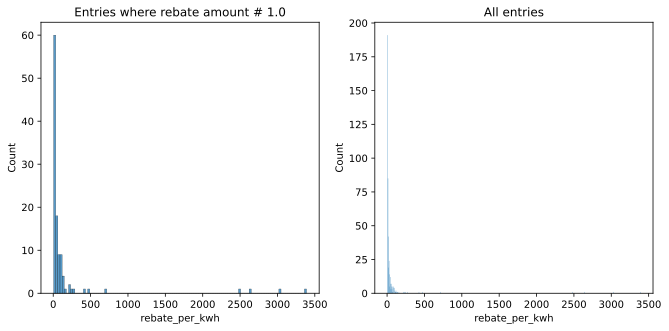

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,5))
sns.histplot(data=higher_5[higher_5.REBATE_AMOUNT != 1], 
            x="rebate_per_kwh", palette="Dark2", ax=ax1)
ax1.set_title('Entries where rebate amount # 1.0')
sns.histplot(data=higher_5, 
            x="rebate_per_kwh", palette="Dark2", ax=ax2)
ax2.set_title('All entries')

plt.show()

In [35]:
# Proportion of rebate amount equal with one
(higher_5.REBATE_AMOUNT == 1).sum()/higher_5.shape[0] * 100

75.49234135667396

In [36]:
# Cases where the rebate per kWh is lower than 5
lower_5 = DPR_rebate[DPR_rebate['rebate_per_kwh'] < 4]
lower_5

CUSTOMER_KEY  EVENT_KEY  ACTUAL_KWH  BASELINE_KWH  REBATE_AMOUNT  \
320        10702420    1000246    3.977999     12.414995            1.0   
491         8635527    1000246    2.195999     10.754997            1.0   
1022        8642061    1000246    4.503997     11.557995            1.0   
1088        8227302    1000246    5.159997     10.840997            1.0   
1296        9070966    1000266    1.196000      1.246000            0.2   
...             ...        ...         ...           ...            ...   
24758       8205773    1000246    3.012999     12.633996            1.0   
25072       8417494    1000246    1.266999     10.846996            1.0   
25546      10690690    1000246    4.659998     13.159998            1.0   
25848      10184056    1000246    6.928998     12.540997            1.0   
26228       8541030    1000246    2.422999     10.962496            1.0   

      PEAK_EVENT_TYPE  pct_ch (%)  rebate_per_kwh  
320               DPR  -67.958110        0.118526  
491               DPR  -79.581594        0.116836  
1022              DPR  -61.031329        0.141764  
1088              DPR  -52.402929        0.176025  
1296              DPR   -4.012841        4.000000  
...               ...         ...             ...  
24758             DPR  -76.151655        0.103939  
25072             DPR  -88.319356        0.104384  
25546             DPR  -64.589675        0.117647  
25848             DPR  -44.749225        0.178190  
26228             DPR  -77.897378        0.117103  

[131 rows x 8 columns]

In [37]:
# Proportion of rebate amount equal with one
(lower_5.REBATE_AMOUNT == 1).sum()/lower_5.shape[0] * 100

99.23664122137404

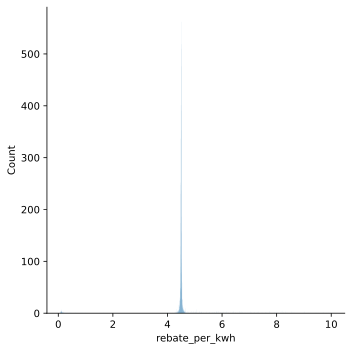

In [38]:
sns.displot(data=DPR_rebate[DPR_rebate['rebate_per_kwh'] < 10], x="rebate_per_kwh", palette="Dark2")

plt.show()

We see that both of these cases the vast majority is where we have rebate amounts equal to 1. These values are do not depend on the percentage or absolute decrease of the consumption and, given there is no reference of a minimum rebate amount, we consider them spurious. Therefore we keep only the cases where the rebate per kWh is around the 4.5 value. We accept some small variation around 4.5 because of the rounding up of numbers.

So it seems that the rebate amount per kWh is at AUD 4.5, the same for all customers and peak events. 

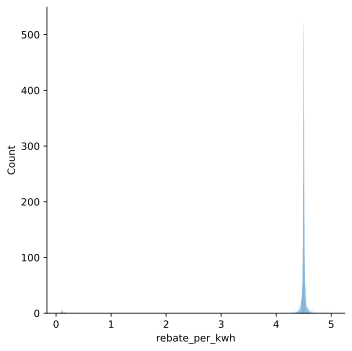

In [39]:
sns.displot(data=DPR_rebate[(DPR_rebate['rebate_per_kwh'] < 5)], 
            x="rebate_per_kwh", palette="Dark2")

plt.show()

Also some **descriptive statistics** of the table are: 

In [40]:
DPR_response_filter_df.drop(['CUSTOMER_KEY', 'EVENT_KEY'], axis=1).describe()

ACTUAL_KWH  BASELINE_KWH  REBATE_AMOUNT    pct_ch (%)
count  12002.000000  12002.000000   12002.000000  12002.000000
mean       3.330650      5.360089      14.501199     34.247180
std        3.619765      4.889243      17.148251    799.551846
min        0.000000      0.013000       0.000000   -100.000000
25%        1.031250      1.865250       2.802500    -70.636570
50%        2.094499      3.935748       9.100000    -40.410197
75%        4.293000      7.404500      19.660000      7.204144
max       39.564500     50.972484     164.800000  66218.750000

Some also descriptive statistics for each DPR event:

In [41]:
DPR_response_filter_df.drop('CUSTOMER_KEY', axis=1).groupby('EVENT_KEY').describe().T

EVENT_KEY               1000240     1000241     1000242      1000244  \
ACTUAL_KWH    count  150.000000  217.000000  789.000000  1041.000000   
              mean     2.906866    3.674003    2.907048     1.929650   
              std      3.718595    4.147594    3.800314     2.124492   
              min      0.000000    0.000000    0.000000     0.000000   
              25%      1.035000    1.070000    0.822000     0.774000   
              50%      1.811999    2.091999    1.601999     1.336000   
              75%      3.110249    4.330999    3.547999     2.256000   
              max     29.106995   31.346989   37.149990    19.448994   
BASELINE_KWH  count  150.000000  217.000000  789.000000  1041.000000   
              mean     3.274924    7.392675    6.503096     5.493907   
              std      2.399852    5.562886    5.724794     5.090873   
              min      0.466194    0.396000    0.070000     0.040000   
              25%      1.778867    2.897999    2.395999     2.067999   
              50%      2.527531    5.912497    4.833998     3.991499   
              75%      3.804547   10.478497    8.923996     7.395997   
              max     17.274495   32.039989   38.850988    43.741989   
REBATE_AMOUNT count  150.000000  217.000000  789.000000  1041.000000   
              mean     4.222000   17.367281   16.755387    16.239577   
              std      6.009365   20.329104   19.601366    19.082746   
              min      0.000000    0.000000    0.000000     0.000000   
              25%      0.000000    2.500000    2.900000     3.400000   
              50%      2.200000    9.900000   10.000000     9.600000   
              75%      5.800000   25.600000   23.700000    22.400000   
              max     33.500000  120.500000  118.900000   164.800000   
pct_ch (%)    count  150.000000  217.000000  789.000000  1041.000000   
              mean   -14.861709  -41.507663  -46.920579   -54.459537   
              std     57.081460   49.860510   53.517139    34.293704   
              min   -100.000000 -100.000000 -100.000000  -100.000000   
              25%    -52.352589  -79.392850  -78.003136   -79.968762   
              50%    -21.280095  -45.785106  -55.357530   -61.715347   
              75%     11.950337  -16.346701  -25.684616   -34.743097   
              max    268.742646  410.405356  739.185969   220.000000   

EVENT_KEY                1000245      1000246      1000248      1000250  \
ACTUAL_KWH    count  1135.000000  1184.000000  1167.000000  1157.000000   
              mean      2.152253     2.528646     2.268215     3.507345   
              std       2.226265     2.795344     2.565149     3.454177   
              min       0.000000     0.000000     0.000000     0.017000   
              25%       0.757500     0.895750     0.753500     1.124000   
              50%       1.431999     1.656999     1.402000     2.527999   
              75%       2.744999     3.072249     2.597499     4.861998   
              max      23.195992    31.935989    24.099989    36.328987   
BASELINE_KWH  count  1135.000000  1184.000000  1167.000000  1157.000000   
              mean      6.234564     5.919768     4.890147     6.865416   
              std       5.237239     5.270487     4.874843     4.536610   
              min       0.107000     0.064000     0.057000     0.100000   
              25%       2.435999     2.233249     1.646250     3.757999   
              50%       4.662999     4.368499     3.274999     5.986998   
              75%       8.463496     8.130998     6.583997     8.982996   
              max      48.359484    50.972484    43.741989    44.830978   
REBATE_AMOUNT count  1135.000000  1184.000000  1167.000000  1157.000000   
              mean     17.135419    13.540287    12.505056    15.563354   
              std      19.686099    18.203517    17.986235    15.064944   
              min       0.000000     0.000000     0.000000     0.000000   
              25%       3.650000     1.400000   

We plot how random households have responded for the various events.

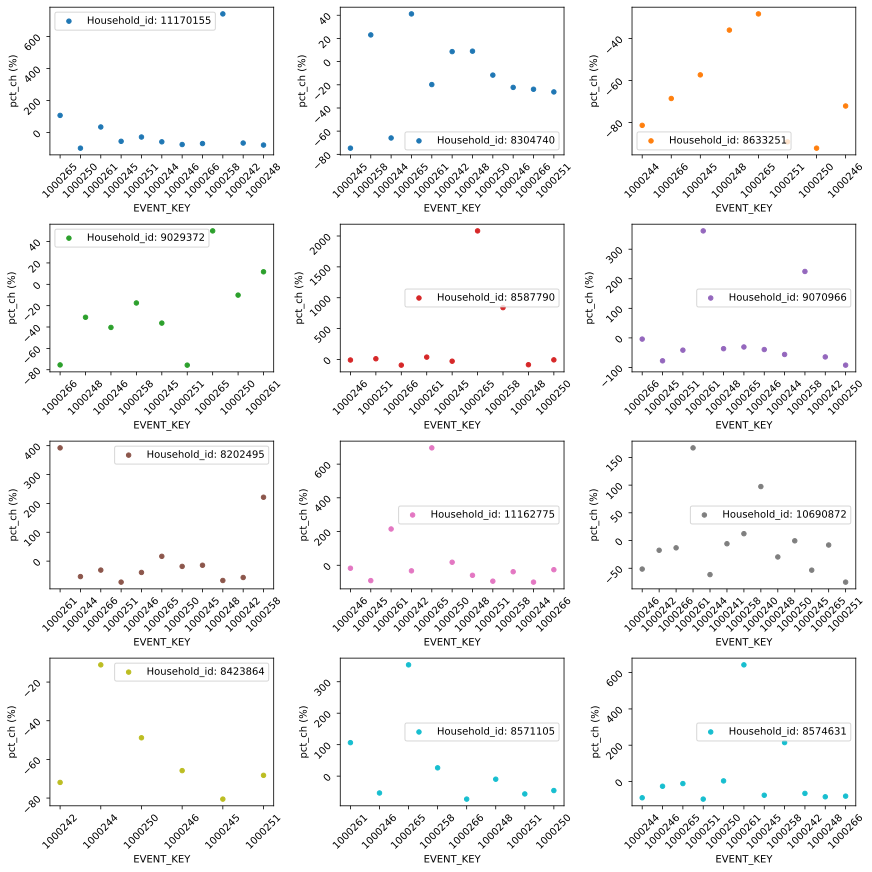

In [42]:
# Convert CUSTOMER_KEY & EVENT_KEY as str
DPR_response_filter_df.CUSTOMER_KEY = DPR_response_df.CUSTOMER_KEY.astype(str)
DPR_response_filter_df['EVENT_KEY'] = DPR_response_filter_df['EVENT_KEY'].astype(str)

# Group them by event and unique customer
DPR_resp_grouped = DPR_response_filter_df.reset_index().groupby('CUSTOMER_KEY')

# Don't use TeX renderer for this plot
rc('text', usetex=False) 

# Number of customers
no_customers = 12

# Get random customers
customer_list = random.choices(population=list(DPR_resp_grouped.groups.keys()), k=no_customers)

# Get non-duplicated random numbers in [0,1] for colors
col_gen_list = np.linspace(start=0, stop=1, num=no_customers)  # list(np.random.uniform(0, 1, size=(no_customers,)))

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

# Get a specific colormap to iterate through
cmap = plt.get_cmap('tab10')

# Plot the percentage change in consumption during DPR events for a number of customers.

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), constrained_layout=True)
axs = trim_axs(axs, len(customer_list))
for ax, customer, color_no in zip(axs, customer_list, col_gen_list):
    DPR_resp_grouped.get_group(customer).plot.scatter(x='EVENT_KEY',
                                                      y='pct_ch (%)',
                                                      color=cmap(color_no), 
                                                      label="Household_id: " + customer, ax=ax)
    
    ax.tick_params(labelrotation=45)
plt.show()

We then go and **plot** the how households have **responded** per DPR event.

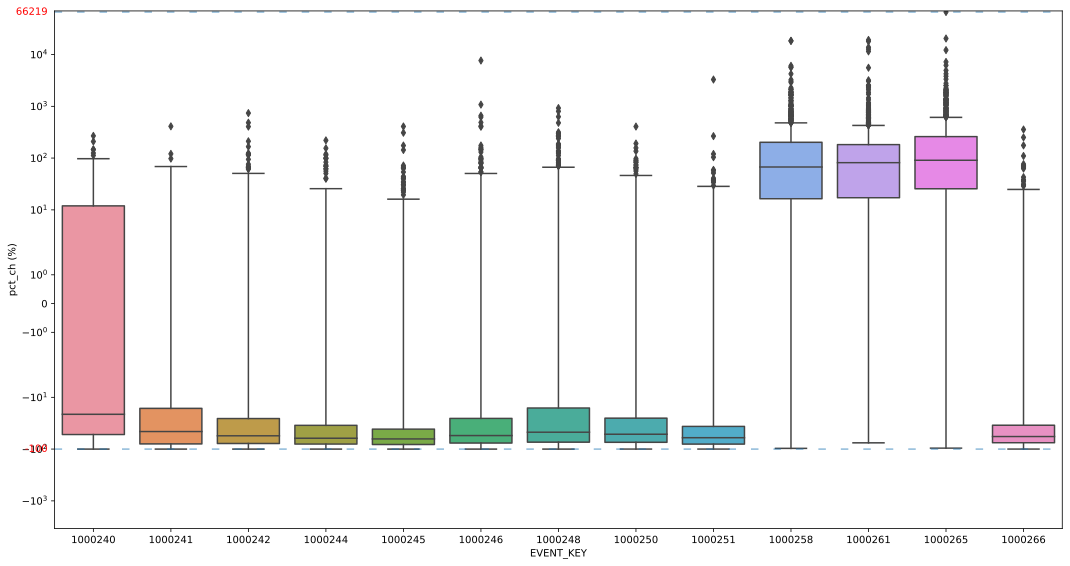

In [43]:
# Don't use TeX renderer for this plot
rc('text', usetex=False)

plt.figure(figsize=(15,8))

ax_box = sns.boxplot(x=DPR_response_filter_df['EVENT_KEY'].astype(int),
                     y=DPR_response_filter_df['pct_ch (%)'])
ax_box.set_yscale("symlog")

# add an horizontal line with the min and the max
min_val = DPR_response_filter_df['pct_ch (%)'].min()
max_val = DPR_response_filter_df['pct_ch (%)'].max()

ax_box.axhline(y=min_val, linestyle='--', dashes=(5, 10), alpha=0.5)
ax_box.axhline(y=max_val, linestyle='--', dashes=(5, 10), alpha=0.5)

# Add min, max values to the horizontal lines
trans = transforms.blended_transform_factory(
    ax_box.get_yticklabels()[0].get_transform(), ax_box.transData)
ax_box.text(0,min_val, "{:.0f}".format(min_val), color="red", transform=trans, 
        ha="right", va="center")
ax_box.text(0,max_val, "{:.0f}".format(max_val), color="red", transform=trans, 
        ha="right", va="center")

plt.tight_layout()

#plt.savefig("images/peak_event_response_distribution.pdf")

plt.show()

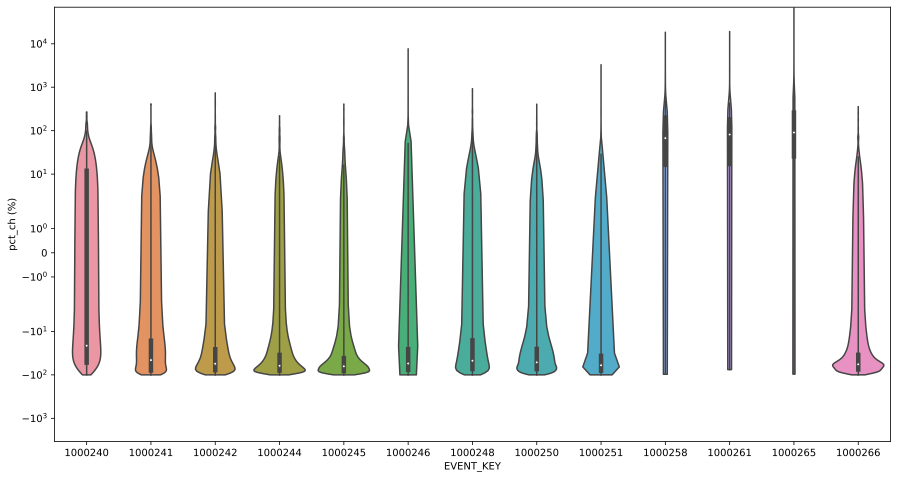

In [44]:
# Don't use TeX renderer for this plot
rc('text', usetex=False)

plt.figure(figsize=(15,8))

ax_violin = sns.violinplot(x=DPR_response_filter_df['EVENT_KEY'].astype(int), 
                           y=DPR_response_filter_df['pct_ch (%)'], cut=0)

                     

# Change the scale of y-axis to `symlog` to allow positive and negative values, 
# and have range around zero within the plot will be linear instead of logarithmic 
ax_violin.set_yscale("symlog")

----
#### Explore weird events

As it is apparent from the above plots, the following events seem to have really high distributions in the percentage difference between the actual and baseline consumption:

* 1000258
* 1000261
* 1000265

We can see in these cases that the really high percentage changes are due to **low baseline estimations**. Also, all 3 of their distributions are skewed towards positive values (non-responding to the DPR scheme). As a result, there is a high probability that potentially something spurious is happening in this case (e.g. problem with baseline estimation values), therefore we **won't take these DPR events under consideration**!

----

We redo the plots for **only the cases where the customers have actually decreased their consumption**.

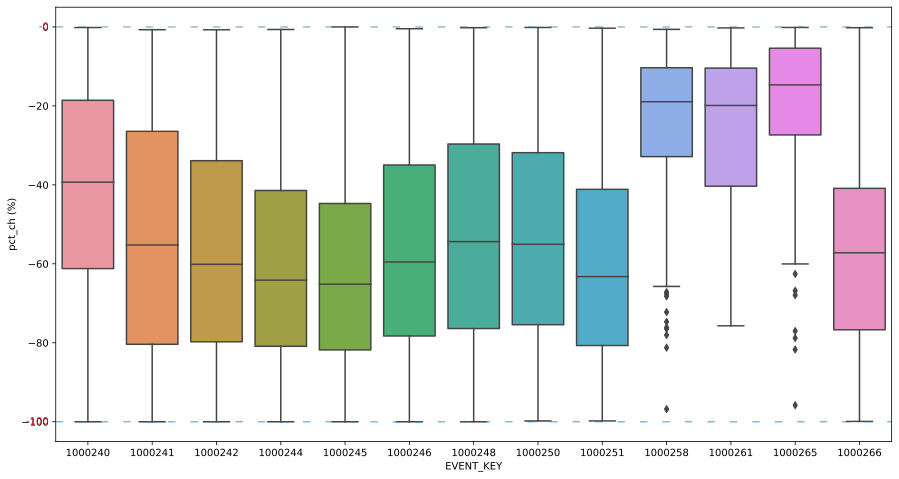

In [45]:
rc('text', usetex=False)

plt.figure(figsize=(15,8))

data_plot_response = DPR_response_filter_df[DPR_response_filter_df['pct_ch (%)'] < 0].reset_index()
data_plot_response['EVENT_KEY'] = data_plot_response['EVENT_KEY'].astype(int)

ax_box = sns.boxplot(x='EVENT_KEY', y='pct_ch (%)', data=data_plot_response)
#ax_box.set_yscale("symlog")

# add an horizontal line with the min and the max
min_val = data_plot_response['pct_ch (%)'].min()
max_val = data_plot_response['pct_ch (%)'].max()

ax_box.axhline(y=min_val, linestyle='--', dashes=(5, 10), alpha=0.5)
ax_box.axhline(y=max_val, linestyle='--', dashes=(5, 10), alpha=0.5)

# Add min, max values to the horizontal lines
trans = transforms.blended_transform_factory(
    ax_box.get_yticklabels()[0].get_transform(), ax_box.transData)
ax_box.text(0,min_val, "{:.0f}".format(min_val), color="red", transform=trans, 
        ha="right", va="center")
ax_box.text(0,max_val, "{:.0f}".format(max_val), color="red", transform=trans, 
        ha="right", va="center")

plt.show()

#### Distribution of number of events households responded and not
When the percentage difference between the actual consumption and the baseline estimation is **lower than 0**, then we say that the household has responded to the DPR events --- because they have actually decreased their electricity consumption in response to the signal ---, and vice versa.

In [46]:
# How many events each customer has responded as they should (increase of actual usage instead of decrease)
DPR_response_filter_df['response'] = DPR_response_filter_df['pct_ch (%)'] <= 0
DPR_response_filter_df['non_response'] = DPR_response_filter_df['pct_ch (%)'] > 0
no_responses_per_house = DPR_response_filter_df.groupby('CUSTOMER_KEY').sum()['response']
no_non_response = DPR_response_filter_df.groupby('CUSTOMER_KEY').sum()['non_response']

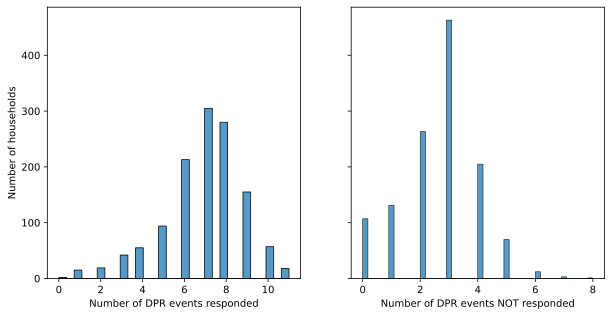

In [47]:
# Histograms showing the distribution of how many customers have (and NOT) responded to DPR events
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
sns.histplot(no_responses_per_house, ax=ax1) #, stat="probability")
sns.histplot(no_non_response, ax=ax2) #, stat="probability")

ax1.set(xlabel='Number of DPR events responded')
ax2.set(xlabel='Number of DPR events NOT responded')
ax1.set(ylabel='Number of households')

plt.show()

----
## Filtered data

We filter out the following data from the dataset:

* **Events with**  `EVENT_KEY`: `1000258`, `1000261`, `1000265` . The percentage difference between the actual and baseline electricity consumption, for all the customers with DPR products, seems to consistently really high (e.g. the median is greater than 100%). This could be attritubed to an error in the baseline estimation for these events (or something else...). Therefore, they are excluded from the analysis/validation of models to avoid biases. 
* **Customers who have participated in less than 5 events**. There should be a minimum number of events in order to have some meaningful statistics.

In [48]:
# Number of households
DPR_response_filter_df['CUSTOMER_KEY'].unique().shape

(1255,)

In [49]:
# Drop rows with the 3 event keys
event_filter_mask = (DPR_response_filter_df.EVENT_KEY != '1000258') & (DPR_response_filter_df.EVENT_KEY != '1000261') & (DPR_response_filter_df.EVENT_KEY != '1000265')
DPR_response_filtered = DPR_response_filter_df[event_filter_mask]

DPR_response_filtered.EVENT_KEY.unique()

array(['1000250', '1000248', '1000266', '1000246', '1000242', '1000244',
       '1000251', '1000241', '1000245', '1000240'], dtype=object)

In [50]:
# Number of households
DPR_response_filtered.index.unique().shape

(9007,)

Then we go and plot distribution of responses with the **filtered data**.

In [51]:
DPR_response_filtered['EVENT_KEY'].astype(int, copy=False)

0        1000250
1        1000248
2        1000266
5        1000246
6        1000242
          ...   
26243    1000245
26244    1000248
26252    1000246
26259    1000245
26260    1000248
Name: EVENT_KEY, Length: 9007, dtype: int32

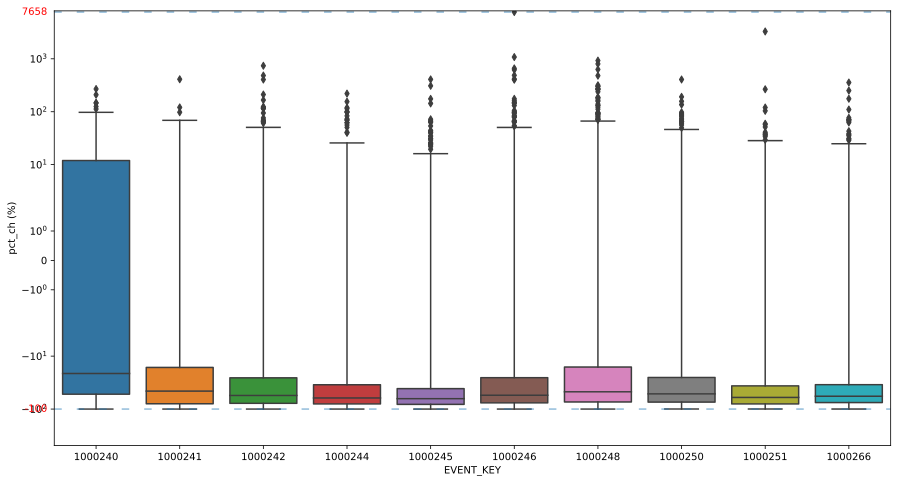

In [52]:
# Don't use TeX renderer for this plot
rc('text', usetex=False)

plt.figure(figsize=(15,8))

ax_box = sns.boxplot(x=DPR_response_filtered['EVENT_KEY'].astype(int), 
                     y=DPR_response_filtered['pct_ch (%)'])
ax_box.set_yscale("symlog")

# add an horizontal line with the min and the max
min_val = DPR_response_filtered['pct_ch (%)'].min()
max_val = DPR_response_filtered['pct_ch (%)'].max()

ax_box.axhline(y=min_val, linestyle='--', dashes=(5, 10), alpha=0.5)
ax_box.axhline(y=max_val, linestyle='--', dashes=(5, 10), alpha=0.5)

# Add min, max values to the horizontal lines
trans = transforms.blended_transform_factory(
    ax_box.get_yticklabels()[0].get_transform(), ax_box.transData)
ax_box.text(0,min_val, "{:.0f}".format(min_val), color="red", transform=trans, 
        ha="right", va="center")
ax_box.text(0,max_val, "{:.0f}".format(max_val), color="red", transform=trans, 
        ha="right", va="center")

#plt.savefig("output/peak_event_response_distribution.pdf")

plt.show()

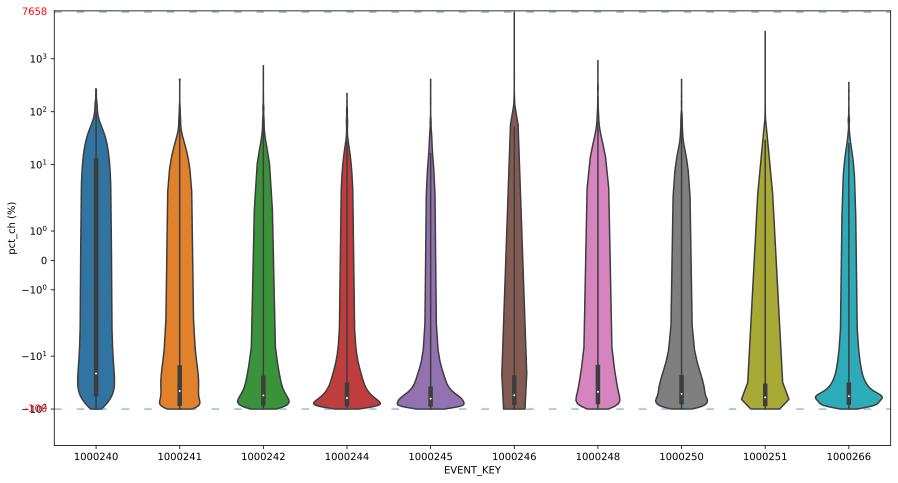

In [53]:
# Don't use TeX renderer for this plot
rc('text', usetex=False)

plt.figure(figsize=(15,8))

ax_violin = sns.violinplot(x=DPR_response_filtered['EVENT_KEY'].astype(int), 
                           y=DPR_response_filtered['pct_ch (%)'], cut=0)

# add an horizontal line with the min and the max
min_val = DPR_response_filtered['pct_ch (%)'].min()
max_val = DPR_response_filtered['pct_ch (%)'].max()

ax_violin.axhline(y=min_val, linestyle='--', dashes=(5, 10), alpha=0.5)
ax_violin.axhline(y=max_val, linestyle='--', dashes=(5, 10), alpha=0.5)

# Add min, max values to the horizontal lines
trans = transforms.blended_transform_factory(
    ax_violin.get_yticklabels()[0].get_transform(), ax_violin.transData)
ax_violin.text(0,min_val, "{:.0f}".format(min_val), color="red", transform=trans, 
        ha="right", va="center")
ax_violin.text(0,max_val, "{:.0f}".format(max_val), color="red", transform=trans, 
        ha="right", va="center")

# Change the scale of y-axis to `symlog` to allow positive and negative values, 
# and have range around zero within the plot will be linear instead of logarithmic 
ax_violin.set_yscale("symlog")

#plt.savefig("images/peak_event_response_distribution_outliers.pdf")

#### *Outlier detection*

There is **still a problem** with really high percentage differences between the actual consumption and the baseline estimation. So we will try to do outlier detection. 

We have approached the problem with unsupervised techniques using **Local Outlier Factor (LOF)**, and **Isolation forest**. For more information on comparison of outlier detection algorithms see [here](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py).

**LOF** measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

* LOF(k) ~ 1 means Similar density as neighbors,
* LOF(k) < 1 means Higher density than neighbors (Inlier),
* LOF(k) > 1 means Lower density than neighbors (Outlier)

**Isolation forest** works on the principle of isolating anomalies. It ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.
This path length, averaged over a forest of such random trees, is a measure of normality and our decision function. Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

The outlier detection will be done on each DPR event, and not on each household. Mainly because the baseline estimation can change through time, and also because the number of DPR events per househols is really small to do any meaningful outlier detection.

The approach we employ here is by using an ensemble of the aforomentioned methods:
* Obtain the anomaly score from isolation forest and prune the dataset to obtain the outlier dataset
* From the outlier dataset use the LOF to get the final outliers.

In [54]:
# Fisrt group the dataframe based on the `EVENT_KEY`
grouped_df_DPR = DPR_response_filtered.groupby('EVENT_KEY')['pct_ch (%)']

def LOF_filter(series, outliers=False):
    # Reshape the series for use with the algo
    X = series.values.reshape(-1, 1)
    # fit the model for outlier detection
    clf = LocalOutlierFactor(contamination=0.4)
    
    if outliers:
        out = series[clf.fit_predict(X) == -1]
    else:
        out = series[clf.fit_predict(X) == 1]
        
    return out

def Isol_Forest_filter(series, outliers=False):
    # Reshape the series for use with the algo
    X = series.values.reshape(-1, 1)
    # fit the model for outlier detection
    clf = IsolationForest(contamination=0.4)
    
    if outliers:
        out = series[clf.fit_predict(X) == -1]
    else:
        out = series[clf.fit_predict(X) == 1]
    
    return out

In [55]:
np.random.seed(seed_value)
# Get the initial outliers set
init_outlier_set = grouped_df_DPR.apply(lambda x: Isol_Forest_filter(x, outliers=True)).reset_index('EVENT_KEY')

# Apply LOF and get the final outliers set
outlier_set = init_outlier_set.groupby('EVENT_KEY')['pct_ch (%)'].apply(lambda x: LOF_filter(x, outliers=True))

In [56]:
# Drop the outliers and create a new dataframe
outlier_mask = DPR_response_filtered['pct_ch (%)'].isin(outlier_set)
DPR_response_outlier_filter = DPR_response_filtered[~outlier_mask]

In [57]:
DPR_response_filtered.shape, DPR_response_outlier_filter.shape

((9007, 9), (7535, 9))

And now we plot **without the outliers** for each DPR event.

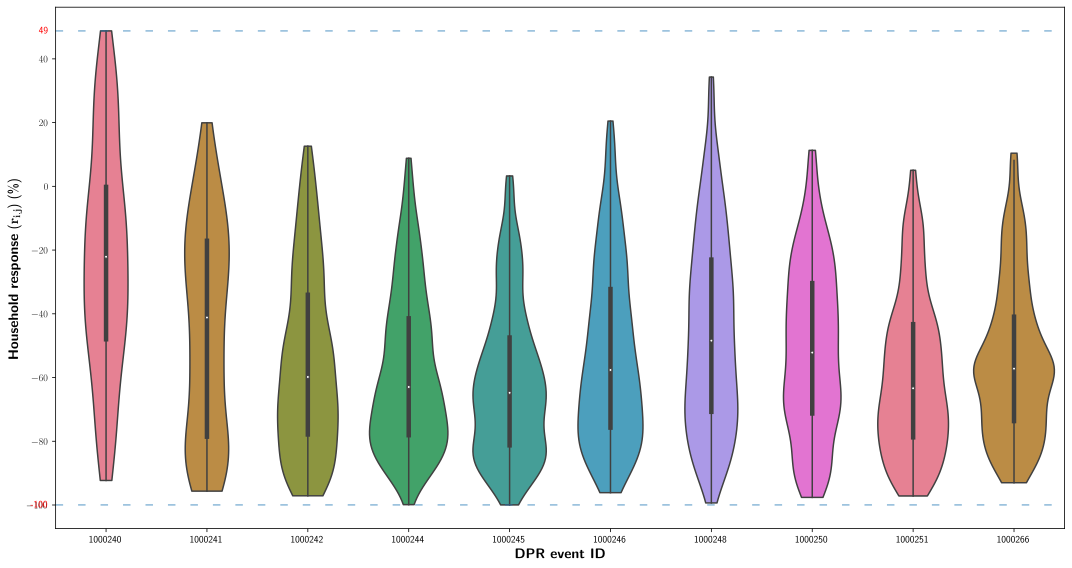

In [58]:
# Don't use TeX renderer for this plot
rc('text', usetex=True)

plt.figure(figsize=(15,8))

ax_box = sns.violinplot(x=DPR_response_outlier_filter['EVENT_KEY'].astype(int),
                        y=DPR_response_outlier_filter['pct_ch (%)'], cut=0, 
                        palette=sns.color_palette("husl", 8))

# add an horizontal line with the min and the max
min_val = DPR_response_outlier_filter['pct_ch (%)'].min()
max_val = DPR_response_outlier_filter['pct_ch (%)'].max()

ax_box.axhline(y=min_val, linestyle='--', dashes=(5, 10), alpha=0.5)
ax_box.axhline(y=max_val, linestyle='--', dashes=(5, 10), alpha=0.5)

# Add min, max values to the horizontal lines
trans = transforms.blended_transform_factory(
    ax_box.get_yticklabels()[0].get_transform(), ax_box.transData)
ax_box.text(0,min_val, "{:.0f}".format(min_val), color="red", transform=trans, 
        ha="right", va="center")
ax_box.text(0,max_val, "{:.0f}".format(max_val), color="red", transform=trans, 
        ha="right", va="center")

ax_box.set_xlabel(r"\textbf{DPR event ID}", fontsize=14)
ax_box.set_ylabel(r"\textbf{Household response} ($\bf{r_{i,j}}$) (\%)", fontsize=14)


plt.tight_layout()

# plt.savefig("images/peak_event_response_distribution_no_outlier.pdf")

plt.show()

In [59]:
# Drop customers with less than 5 events
no_responses_per_house_outlier = DPR_response_outlier_filter.groupby('CUSTOMER_KEY').sum()['response']
event_count_drop_mask = no_responses_per_house_outlier <= 5
event_count_drop_list = no_responses_per_house_outlier.index[event_count_drop_mask]
DPR_response_final = DPR_response_outlier_filter.set_index('CUSTOMER_KEY').drop(index=event_count_drop_list)

In [60]:
# Export it to csv for further analysis
DPR_response_final.reset_index().to_csv('data/DPR_response_filtered.csv', index=False)

----
### Dependence of season, day and time-of-day on response

Check that depend the response depends on time of day, season, and week-day 

In [61]:
# Get the timestampt for each event
peak_event_df

# Keep only 'EVENT_KEY','PEAK_EVENT_TYPE','EVENT_DATE' columns
col_list = ['EVENT_KEY','PEAK_EVENT_TYPE','EVENT_DATE']
peak_event_df = peak_event_df[col_list]

# Convert the columns to datetime 
peak_event_df.loc[:,'EVENT_DATE'] = pd.to_datetime(peak_event_df.loc[:,'EVENT_DATE'], format='%d/%m/%Y %H:%M').copy()

# Keep only DPR events
DPR_event_df = peak_event_df[peak_event_df.PEAK_EVENT_TYPE == 'DPR']

In [62]:
# Create weekday, month, time-of-day columns
DPR_event_df.loc[:, 'Day'] = DPR_event_df.EVENT_DATE.dt.day_name().values
DPR_event_df.loc[:, 'Month'] = DPR_event_df.EVENT_DATE.dt.month.values
DPR_event_df.loc[:, 'Hour'] = DPR_event_df.EVENT_DATE.dt.hour.values

# Set event_key as an index
DPR_event_df.set_index('EVENT_KEY', inplace=True)

C:\Users\anton\Anaconda3\envs\visualisation\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\anton\Anaconda3\envs\visualisation\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [63]:
# Merge on the event_key
DPR_response_outlier_filter['EVENT_KEY'] = pd.to_numeric(DPR_response_outlier_filter['EVENT_KEY'])
merged_time_resp = pd.merge(DPR_event_df[['Day', 'Month', 'Hour']].reset_index(), 
                            DPR_response_outlier_filter, on='EVENT_KEY')

<ipython-input-63-87c02fa2081d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DPR_response_outlier_filter['EVENT_KEY'] = pd.to_numeric(DPR_response_outlier_filter['EVENT_KEY'])


In [64]:
# Create season masks
winter_mask = merged_time_resp.Month.isin([6,7,8])
spring_mask = merged_time_resp.Month.isin([9,10,11])
summer_mask = merged_time_resp.Month.isin([12,1,2])
autumn_mask = merged_time_resp.Month.isin([3,4,5]) 

# Create the season column
merged_time_resp['season'] = np.zeros(merged_time_resp.shape[0], dtype='str')

merged_time_resp.loc[winter_mask, 'season'] = 'winter'
merged_time_resp.loc[spring_mask, 'season'] = 'spring'
merged_time_resp.loc[summer_mask, 'season'] = 'summer'
merged_time_resp.loc[autumn_mask, 'season'] = 'autumn'

In [84]:
# Export it to csv for further analysis
# merged_time_resp.reset_index().to_csv('data/DPR_response_filtered_season.csv', index=False)

We now plot graphs to see if there is some dependency on the season, month, day, etc.

##### Season

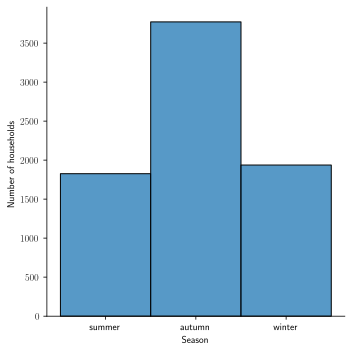

In [65]:
# Histogram showing the distribution of households responded per season
sns.displot(merged_time_resp['season']) #, stat="probability")
plt.xlabel('Season')
plt.ylabel('Number of households')
plt.show()

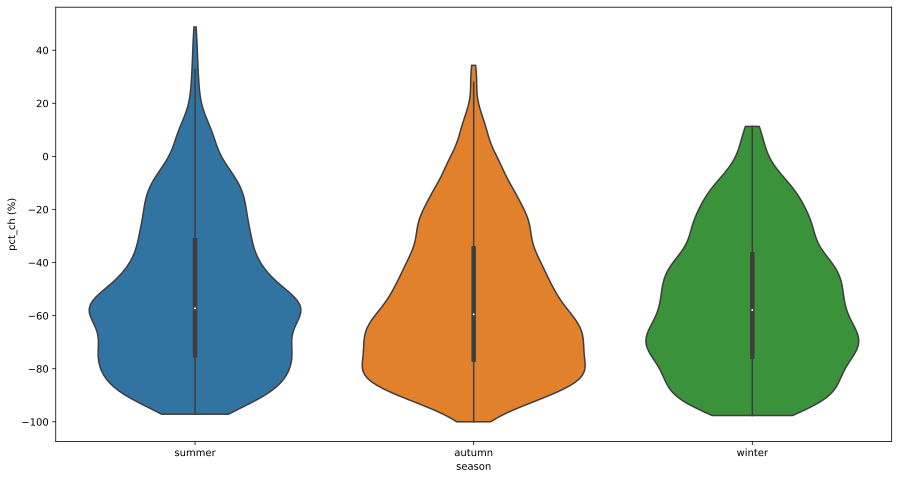

In [66]:
# Don't use TeX renderer for this plot
rc('text', usetex=False)

# Plot the seaborn graph
plt.figure(figsize=(15,8))

ax_box = sns.violinplot(x='season', y='pct_ch (%)', data=merged_time_resp, cut=0)

plt.show()

##### Month

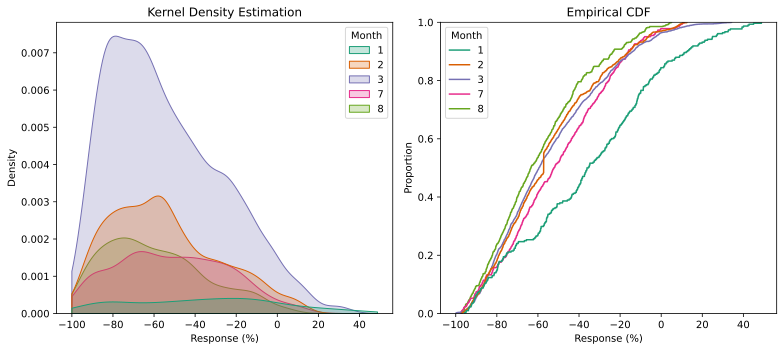

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,5))

max_response = merged_time_resp['pct_ch (%)'].max()

# KDE distributions for the various seasons
sns.kdeplot(data=merged_time_resp, x="pct_ch (%)", 
            hue="Month", fill=True, clip=(-100, max_response), 
            palette="Dark2", ax=ax1)
# Empirical cdf plot for each season
sns.ecdfplot(data=merged_time_resp, x="pct_ch (%)", 
            hue="Month", 
            palette="Dark2", ax=ax2)

ax1.set(xlabel='Response (%)')
ax1.set_title('Kernel Density Estimation')
ax2.set(xlabel='Response (%)')
ax2.set_title('Empirical CDF')

plt.tight_layout()

# plt.savefig("images/dist_plot_response_month.pdf", transparent=True)

plt.show()

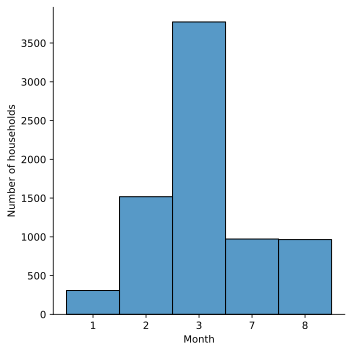

In [68]:
# Histogram showing the distribution of households responded per season
sns.displot(merged_time_resp['Month'].astype(str)) #, stat="probability")
plt.xlabel('Month')
plt.ylabel('Number of households')
plt.show()

##### Day

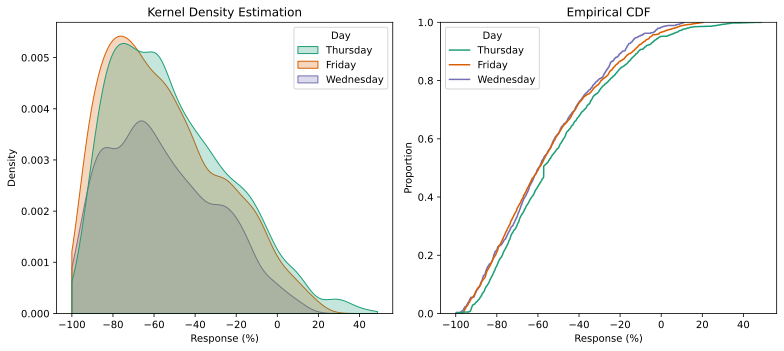

In [69]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,5))

max_response = merged_time_resp['pct_ch (%)'].max()

# KDE distributions for the various seasons
sns.kdeplot(data=merged_time_resp, x="pct_ch (%)", 
            hue="Day", fill=True, clip=(-100, max_response), 
            palette="Dark2", ax=ax1)
# Empirical cdf plot for each season
sns.ecdfplot(data=merged_time_resp, x="pct_ch (%)", 
            hue="Day", palette="Dark2", ax=ax2)

ax1.set(xlabel='Response (%)')
ax1.set_title('Kernel Density Estimation')
ax2.set(xlabel='Response (%)')
ax2.set_title('Empirical CDF')

plt.tight_layout()

# plt.savefig("images/dist_plot_response_day.pdf", transparent=True)

plt.show()

##### Hour

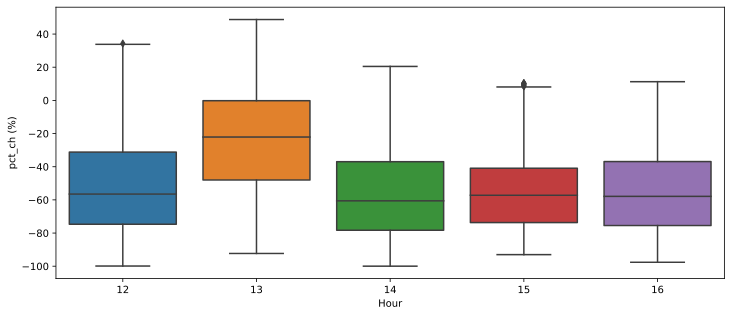

In [70]:
# Don't use TeX renderer for this plot
rc('text', usetex=False)

# Plot the seaborn graph
plt.figure(figsize=(12,5))

ax_box = sns.boxplot(x='Hour', y='pct_ch (%)', data=merged_time_resp)

plt.show()

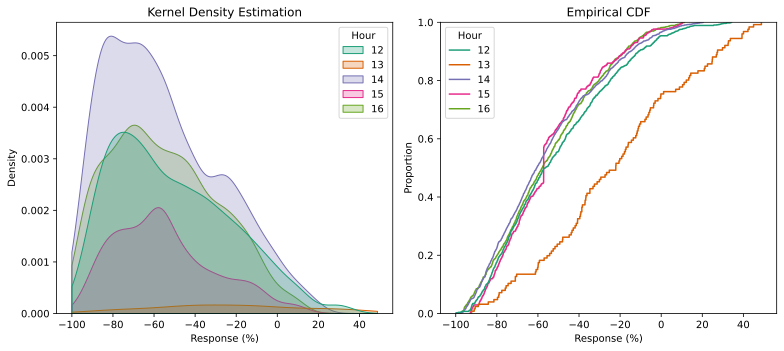

In [71]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,5))
rc('text', usetex=False)

max_response = merged_time_resp['pct_ch (%)'].max()

# KDE distributions for the various seasons
sns.kdeplot(data=merged_time_resp, x="pct_ch (%)", 
            hue="Hour", fill=True, clip=(-100, max_response), 
            palette="Dark2", ax=ax1)
# Empirical cdf plot for each season
sns.ecdfplot(data=merged_time_resp, x="pct_ch (%)", 
            hue="Hour", palette="Dark2", ax=ax2)

ax1.set(xlabel='Response (%)')
ax1.set_title('Kernel Density Estimation')
ax2.set(xlabel='Response (%)')
ax2.set_title('Empirical CDF')

plt.tight_layout()

# plt.savefig("images/dist_plot_response_hour.pdf", transparent=True)

plt.show()

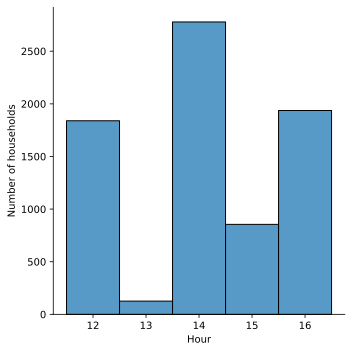

In [72]:
# Histogram showing the distribution of households responded per season
sns.displot(merged_time_resp['Hour'].astype(str).sort_values()) #, stat="probability")
plt.xlabel('Hour')
plt.ylabel('Number of households')
plt.show()

In [73]:
# Write seasonal dataframe to csv
merged_time_resp.to_csv('data/response_data_season.csv', index=False)

---
### Distribution exploration
#### Target variable (Response per household and per event)
First we try to see how household have responded per household and per event. Fir

In [74]:
merged_time_resp.head()

EVENT_KEY       Day  Month  Hour CUSTOMER_KEY  ACTUAL_KWH  BASELINE_KWH  \
0    1000240  Thursday      1    13     10690824    0.830000      1.352379   
1    1000240  Thursday      1    13     10690860    1.399999      1.762166   
2    1000240  Thursday      1    13      9909720    0.702000      3.131673   
3    1000240  Thursday      1    13     10041674    7.099998      4.972373   
4    1000240  Thursday      1    13     10233662    1.026000      2.203599   

   REBATE_AMOUNT PEAK_EVENT_TYPE  pct_ch (%)  response  non_response  season  
0            2.4             DPR  -38.626672      True         False  summer  
1            1.6             DPR  -20.552377      True         False  summer  
2           10.9             DPR  -77.583867      True         False  summer  
3            0.0             DPR   42.788926     False          True  summer  
4            5.3             DPR  -53.439805      True         False  summer

Let's plot the distribution of the target variable including all seasons and across seasons.

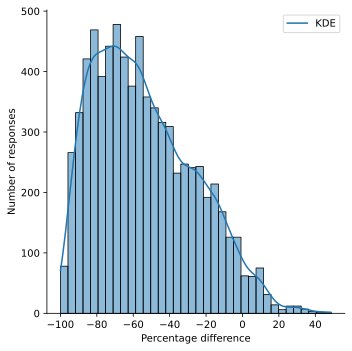

In [75]:
# Histogram showing the distribution of how many customers have responded to how many events
sns.displot(merged_time_resp['pct_ch (%)'], kde=True) #, stat="probability")
plt.xlabel('Percentage difference')
plt.ylabel('Number of responses')
plt.legend(['KDE'])
plt.show()

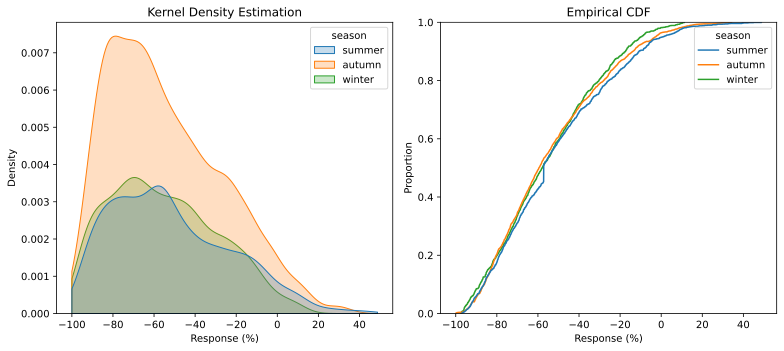

In [76]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,5))

max_response = merged_time_resp['pct_ch (%)'].max()

# KDE distributions for the various seasons
sns.kdeplot(data=merged_time_resp, x="pct_ch (%)", 
            hue="season", fill=True, clip=(-100, max_response), ax=ax1)
# Empirical cdf plot for each season
sns.ecdfplot(data=merged_time_resp, x="pct_ch (%)", 
            hue="season", ax=ax2)

ax1.set(xlabel='Response (%)')
ax1.set_title('Kernel Density Estimation')
ax2.set(xlabel='Response (%)')
ax2.set_title('Empirical CDF')

plt.tight_layout()

#plt.savefig("images/dist_plot_response_season.pdf", transparent=True)

plt.show()

So, we can see that **both** the distributions of **responses aggregated** and for **each season** seem to follow a distribution similar to a **log-normal** distribution. As we can see above the distribution of the responses of the various households for the DPR events are not following a symmetric distribution, but it seems to be skewed towards left. In cases where you have a skewed distribution, the median is often the best measure of central tendency.

#### Target variable (Median Response per household)
In this case we will use as the target variable the median response (of the participated peak events) for each household. 

First we need to calculate the median response per household for the filtered data.

In [77]:
drop_list = ['EVENT_KEY', 'Day', 'Month', 'Hour', 'season']
median_response = merged_time_resp.drop(drop_list, axis=1).groupby('CUSTOMER_KEY').describe()[('pct_ch (%)', '50%')]

In [78]:
median_response.rename("median_response", inplace=True)

CUSTOMER_KEY
10017898   -39.657478
10017932   -23.825065
10018216   -66.699102
10018244   -79.235635
10041256   -51.238649
              ...    
9985642    -32.646692
9986640    -65.762235
9994458    -34.514830
9994510    -43.757688
9994536    -28.301519
Name: median_response, Length: 1252, dtype: float64

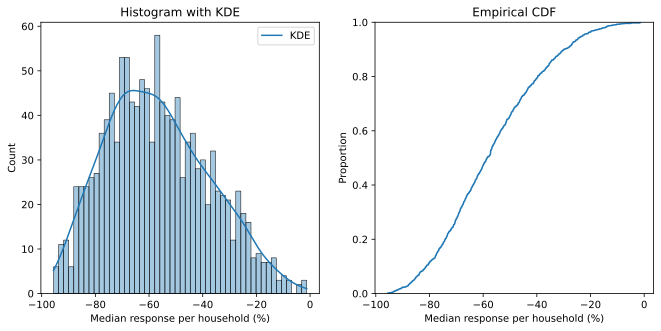

In [79]:
# Histogram showing the distribution of the median response per household
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,5))

# Histrogram with KDE distributions
sns.histplot(median_response, alpha=0.4, bins=50, kde=True, ax=ax1)

# Empirical cdf plot 
sns.ecdfplot(median_response, ax=ax2)

ax1.set(xlabel='Median response per household (%)')
ax1.legend(['KDE'])
ax1.set_title('Histogram with KDE')
ax2.set(xlabel='Median response per household (%)')
ax2.set_title('Empirical CDF')

plt.show()

So, we can see that the distribution of the median response per household follows a distribution somewhat between a **log-normal** and a **normal** distribution.

In [80]:
# Write median response per household in a csv file
median_response.reset_index().to_csv('data/median_response_per_household.csv', index=False)

#### Target variable (Median Response of each household per season)
Next we try to see how households have responded per season. In this case we will use as the target variable the median response (of the participated peak events) for each household, per season.

First we need to calculate the median response per household per season for the filtered data.

In [81]:
# Group them based on season and household
drop_list = ['EVENT_KEY', 'Day', 'Month', 'Hour']
season_grouped = merged_time_resp.drop(drop_list, axis=1).groupby(['season', 'CUSTOMER_KEY'])

# Create median response df
median_response_season = season_grouped.describe()[('pct_ch (%)', '50%')]
median_response_season.rename("median_response", inplace=True)

season  CUSTOMER_KEY
autumn  10017898       -29.658620
        10017932       -23.825065
        10018216       -67.989576
        10018244       -78.087529
        10041256       -51.238649
                          ...    
winter  9985388        -28.976257
        9985642        -13.203176
        9986640        -53.810502
        9994458        -39.569338
        9994510        -38.980364
Name: median_response, Length: 3372, dtype: float64

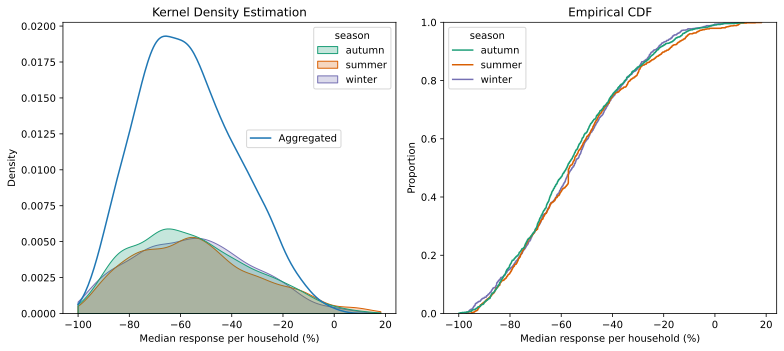

In [82]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,5))

max_response = median_response_season.reset_index()['median_response'].max()

# KDE distributions for the various seasons
sns.kdeplot(data=median_response_season.reset_index(), x="median_response", 
            hue="season", fill=True, clip=(-100, max_response), palette="Dark2", 
            legend=True, ax=ax1)
g = sns.kdeplot(data=median_response.reset_index(), x="median_response", 
            fill=False, clip=(-100, max_response), label='Aggregated',
            legend=True, ax=ax1)
handle, label = g.get_legend_handles_labels()
leg = Legend(g, handle, label, loc='center right', bbox_to_anchor=(0.85,0.6), frameon=True)
ax1.add_artist(leg);

# Empirical cdf plot for each season
sns.ecdfplot(data=median_response_season.reset_index(), x="median_response", 
            hue="season", palette="Dark2", ax=ax2)

ax1.set(xlabel='Median response per household (%)')
ax1.set_title('Kernel Density Estimation')
ax2.set(xlabel='Median response per household (%)')
ax2.set_title('Empirical CDF')

plt.tight_layout()

plt.savefig("images/dist_median_season.pdf", transparent=True)

plt.show()

In [83]:
# Write median response per household in a csv file
median_response_season.reset_index().to_csv('data/median_response_household_per_season.csv', index=False)